# 신경망 모델 훈련

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hg-mldl2/blob/main/07-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [63]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import keras
import tensorflow as tf

keras.utils.set_random_seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

## 손실 곡선

In [64]:
import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [65]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28,28)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [66]:
model = model_fn()
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)
#fit 메소드를 사용하면, 반환값이 있음.
#(손실, 정확도, 에포크 횟수 등)

In [68]:
# key로 accuracy, loss 가 있음.
# accuracy 는 위에서 metrics로 넣어서 있다 ?
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


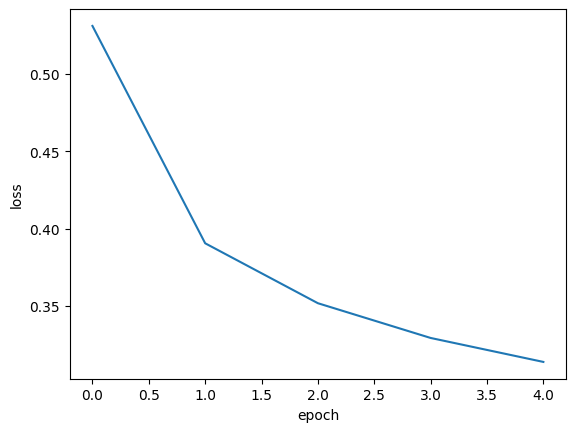

In [69]:
import matplotlib.pyplot as plt

# 에포크가 줄어들수록 손실이 줄어든다.
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

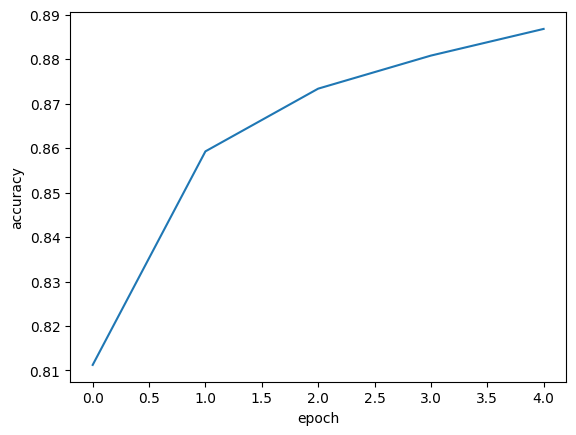

In [70]:
# 에포크가 줄어들수록 정확도가 올라간다.
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [71]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

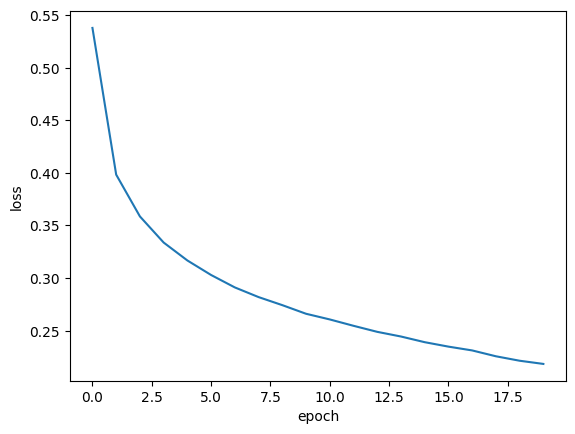

In [72]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

이전에 검증 데이터를 이용하여, 그래프를 그려봤을때를 생각

-> 훈련을 진행할수록 손실이 줄어들다가 어느순간 일정함. 혹은 손실이 더 커질수도 있음.

-> **이 지점을 알아내야한다**


## 검증 손실

In [73]:
# 검증 데이터를 validation_data에 넣음.

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

In [74]:
# 검증 세트에 대한 key가 새로 생겨남을 알 수 있다.
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


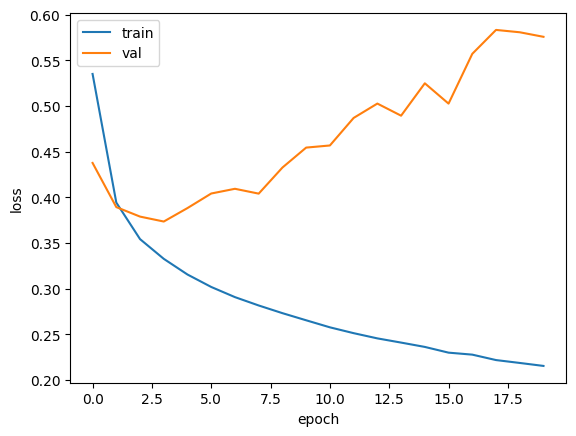

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# 과대적합이 2.5 조금 넘어서 바로 나옴..

In [76]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

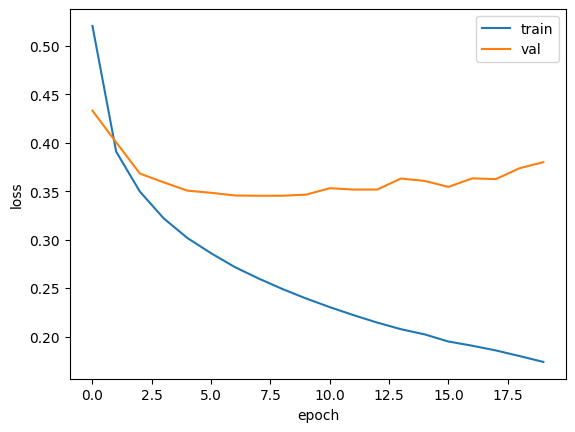

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 드롭아웃

은닉층에 있는 뉴런을 랜덤하게 꺼버림 ( 뉴런의 출력을 0으로 바꾸어 과대적합 방지 )

어떤 유닛은 결과게 큰 영향을 줄수도 있고.. 안주는 유닛도 있음

or

의존적인 유닛들도 존재할 수있다.

=> 랜덤하게 꺼버리면 과도하게 의존하는것을 방지 가능.

**훈련 시에만 드롭 아웃!**

**추론 시에는 모든 뉴런 사용!**

In [78]:
# 30% 를 드롭아웃
model = model_fn(keras.layers.Dropout(0.3))

# Dropout 은 0임
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_22 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target))

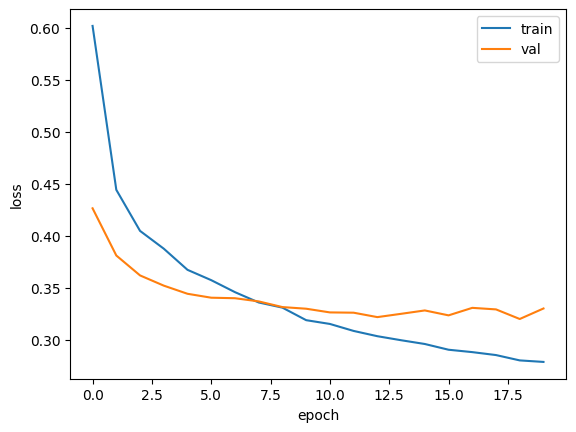

In [80]:
# 검증 세트의 손실이 많이 억제 되고, 훈련세트와 비슷하게 간다.

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 모델 저장과 복원

저장을 하고 재사용 하기 위함. (직렬화 / 역직렬화)

In [81]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=11, verbose=0,
                    validation_data=(val_scaled, val_target))

In [82]:
# 확장자를 keras로 해서 모델을 저장
model.save('model-whole.keras')

In [83]:
# 가중치만 저장
model.save_weights('model.weights.h5')

In [84]:
!ls -al model*

-rw-r--r-- 1 root root 976600 Jul 12 01:53 model.weights.h5
-rw-r--r-- 1 root root 979395 Jul 12 01:53 model-whole.keras


In [85]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model.weights.h5')

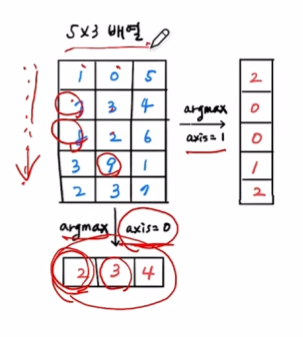

In [86]:
# axis 가 0 이면 -> 행을 따라서 가장 큰 값의 인덱스를 가져옴. 사진상 3개의 출력.
# axis 가 1 이면 -> 열을 따라서 가장 큰 값의 인덱스를 가져옴. 사진상 5개 출력

import numpy as np

# -1도 1과 같음.. 왜 ?
# 차원이 몇개가 있는지 정확히 모를때 -1로 사용 하여 최대값 가져오기.
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.8829166666666667


In [87]:
# 모델 객체를 전부 로드
# keras를 호출했기에 손실 함수, 옵티마이저 등 모두 복원이 되기에 evaluate가 가능함.

model = keras.models.load_model('model-whole.keras')
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8856 - loss: 0.3216


[0.32348448038101196, 0.8829166889190674]

## 콜백

검증 값에서 가장 좋은 성능을 낸 모델을 찾아서 가져옴.

In [ ]:
# best-model.keras 저장할 파일명.
# save_best_only 최고값을 이용하기.
#

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras',
                                                save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [ ]:
model = keras.models.load_model('best-model.keras')
model.evaluate(val_scaled, val_target)

# 조기종료

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras',
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
print(early_stopping_cb.stopped_epoch)
# 12번 == 13번지

# patience = 2 로 하였으니 최고의 모델은 애포크가 10(11번지)임.

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model.evaluate(val_scaled, val_target)